# Content Based 3d Model Retrieval

### How are voxels counted? 
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

### plotting voxels in matplotlib

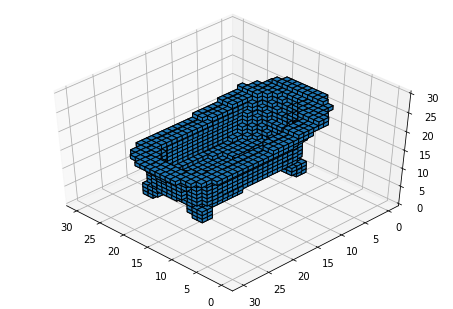

In [2]:
import matplotlib.pyplot as plt
from plots import plot_vox_file
%matplotlib inline


plot_vox_file('./ModelNet10/bathtub/train/bathtub_0005.binvox')

## Evaluate class balance for ModelNet10 and ModelNet40

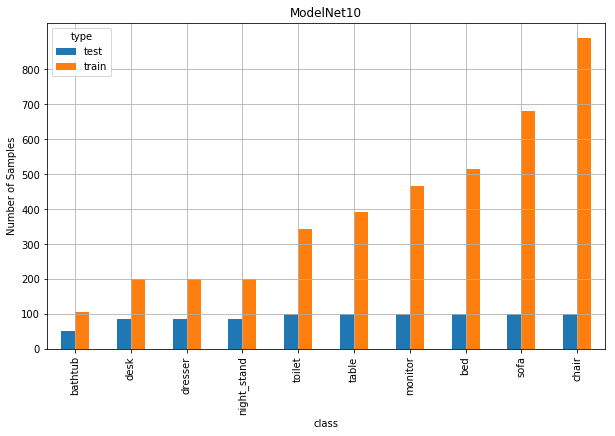

type,test,train
class,,
bathtub,50,106
desk,86,200
dresser,86,200
night_stand,86,200
toilet,100,344
table,100,392
monitor,100,465
bed,100,515
sofa,100,680


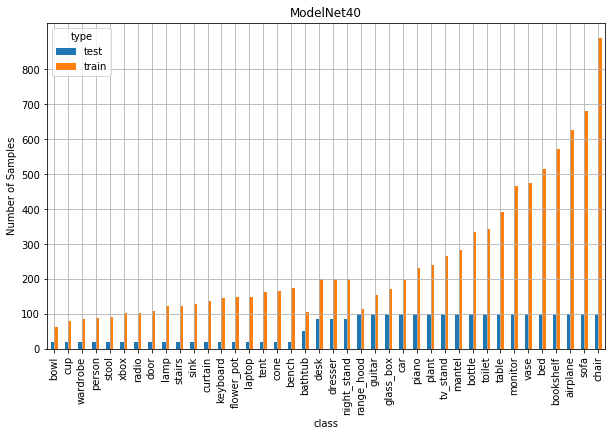

type,test,train
class,,
bowl,20,64
cup,20,79
wardrobe,20,87
person,20,88
stool,20,90
xbox,20,103
radio,20,104
door,20,109
lamp,20,124


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from count_files import (make_file_description_data_frame,
                         plot_class_balance)

df = make_file_description_data_frame('./ModelNet10/', show_missed=False)
plot_class_balance(df, 'ModelNet10')

df = make_file_description_data_frame('./ModelNet40/', show_missed=False)
plot_class_balance(df, 'ModelNet40')

## Get the Data

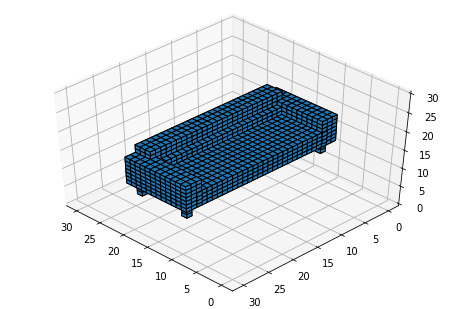

This is a sofa.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from data import load_data
from plots import plot_vox

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')

plot_vox(x_train[0].reshape(30, 30, 30)), \
print("This is a {}.".format(target_names[y_train[0]]));

## Run a simple Keras model

### Quick Replication of 3DShapeNets study (not looking to get exact)

In [90]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from data import load_data
from plots import plot_vox

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

np.random.seed(42)
train_indices = np.random.choice(np.arange(0, y_train.shape[0]), y_train.shape[0], replace=False)

x_train = x_train[train_indices]
y_train = y_train[train_indices]

balance (with random selection) 

train vs valid split looks good, but the classes are really imbalanced. 

Going to upsample

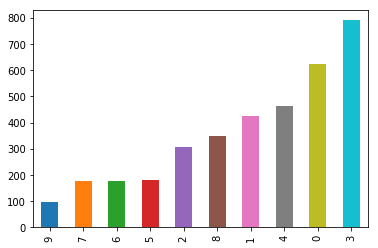

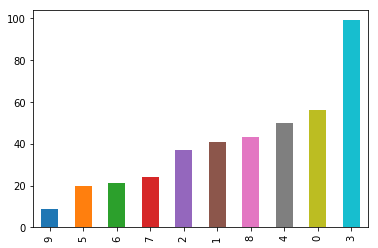

In [91]:
import pandas as pd

df = pd.DataFrame(y_train)

train = df.iloc[:3591]
valid = df.iloc[3591:]

train[0].value_counts().sort_values().plot(kind='bar')
plt.figure()
valid[0].value_counts().sort_values().plot(kind='bar')

array([0, 0, 0, ..., 9, 9, 9])

how to upsample just one of them

In [83]:
y_train[y_train == 0].shape

(680,)

In [85]:
y_train[y_train == 9].shape

(106,)

what is the highest number of samples

upsample

stratified split

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

In [50]:
sss = StratifiedShuffleSplit(1)

thing = sss.split(x_train, y_train)

a = [i for i in thing][0]
# a = [i for i in thing]

a[0].shape, a[1].shape

((3591,), (400,))

###### Upsample under represented classes

Looks like they used upsampling to deal with class imbalance
see: `balance_data.m` from code associated with http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

### Before stratified

Balancing through upsampling should be done

##### description of layers from run_pretrain.m code in 3DShapeNets code


```
param.network = {
    struct('type', 'input');
    struct('type', 'convolution', 'outputMaps', 48, 'kernelSize', 6, 'actFun', 'sigmoid', 'stride', 2);
    struct('type', 'convolution', 'outputMaps', 160, 'kernelSize', 5, 'actFun', 'sigmoid', 'stride', 2);
    struct('type', 'convolution', 'outputMaps', 512, 'kernelSize', 4, 'actFun', 'sigmoid', 'stride', 1);
    struct('type', 'fullconnected', 'size', 1200, 'actFun', 'sigmoid');
    struct('type', 'fullconnected', 'size', 4000, 'actFun', 'sigmoid');
};
```

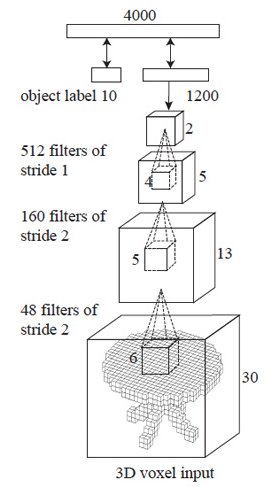

# Make sure you're balancing classes

In [17]:
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


model = Sequential()
model.add(Conv3D(48, 6, strides=2,
                 padding='same',
                 activation='relu',
                 input_shape=(30, 30, 30, 1)))
model.add(Conv3D(160, 5, strides=2,
                 padding='same',
                 activation='relu'))
model.add(Conv3D(512, 4, strides=1,
                 padding='same',
                 activation='relu'))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='softmax'))

# ### TODO: Define your architecture.

model.summary()
model.compile('rmsprop', 'categorical_crossentropy', metrics=['accuracy'])

In [9]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(x_train, y_train,
          epochs=15,
          batch_size=128,
          shuffle=True,
          validation_split=.25,
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

model.evaluate(x_test, y_test)

Train on 2993 samples, validate on 998 samples
Epoch 1/10
2993/2993 [==============================] - 61s 20ms/step - loss: 13.4182 - acc: 0.1336 - val_loss: 14.1316 - val_acc: 0.1232

Epoch 00001: val_loss improved from inf to 14.13160, saving model to weights.best.hdf5
Epoch 2/10
2993/2993 [==============================] - 51s 17ms/step - loss: 14.0071 - acc: 0.1310 - val_loss: 14.1316 - val_acc: 0.1232

Epoch 00002: val_loss did not improve
Epoch 3/10
2993/2993 [==============================] - 51s 17ms/step - loss: 14.0071 - acc: 0.1310 - val_loss: 14.1316 - val_acc: 0.1232

Epoch 00003: val_loss did not improve
Epoch 4/10
2993/2993 [==============================] - 51s 17ms/step - loss: 14.0125 - acc: 0.1306 - val_loss: 14.1316 - val_acc: 0.1232

Epoch 00004: val_loss did not improve
Epoch 5/10
2176/2993 [====================>.........] - ETA: 12s - loss: 14.0144 - acc: 0.1305

KeyboardInterrupt: 

In [10]:
model.evaluate(x_test, y_test)

908/908 [==============================] - 5s 6ms/step


[14.342974767810972, 0.11013215859030837]

# Try optimizing these parameters?

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model = make_shapenets_model()
model.fit(x_train, y_train,
          epochs=15,
          batch_size=128,
          shuffle=True,
          validation_split=.25,
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

model.evaluate(x_test, y_test)

trying last configuration in pretrain.m first
```
param = [];
param.layer = 6;
param.epochs = 150;
param.lr = 0.003;
param.weight_decay = 1e-5;
param.momentum = [0.5, 0.5];
param.kPCD = 1;
param.persistant = 1;
param.batch_size = 32;
param.sparse_damping = 0;
param.sparse_target = 0;
param.sparse_cost = 0;
new_list = balance_data(data_list,param.batch_size);
[model] = rbm_last(model, new_list, [train_label, hidden_prob_h5], param);
```

# Have you augmented the data like the 3DShapeNets paper?

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model = make_shapenets_model()
model.fit(x_train, y_train,
          epochs=15,
          batch_size=128,
          shuffle=True,
          validation_split=.25,
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

model.evaluate(x_test, y_test)

# Appendix: